In [3]:
import numpy as np
import matplotlib.pyplot as plt
import sys
import time

In [4]:
path = '../PostBornEma/'
sys.path.append("../scripts/") 
from lab import *


# Vanessa's implementations of $G^{ab}$s

### 1) $ G_l^{\phi\psi}(\chi_{max}, \chi_2) = \int_0^{\chi_{max}} \mathrm{d} \chi_1 W(\chi_1, \chi_{max}) C_l^{\psi\psi}(\chi_1,\chi_2)$ 
$= \mathcal{A}^2 \frac{1}{2\pi^2} \sum_n \int_0^1  \chi_2^{(1-\nu_n)} [1+z(\chi_2)] D(\chi_2) I^0_l (\nu_n,t)\left[W(t\chi_2,\chi_{max}) D(\chi_2 t) [1+z(\chi_2 t)] + W(1/t \chi_2,\chi_{max}) t^{\nu_n-2}D(\chi_2/t)[1+z(\chi_2/t)]\right]$

needs to be evaluated for varying $\chi_{max}$ and $\chi_2$ (this appears in Eq. 4.2).

replacing $\chi_2$ by $r\chi_{max}$ allows doing basically the same as before, just without summing over $r$,
so that the ouput for fixed $\chi_{max}$ has shape of $r$.
Then we only need one loop over $\chi_{max}$.

In [47]:
# agrees with parallelized code and agrees with Chirag's code
def lensing_kernel(xi, xmax):
    return (xmax - xi)/(xmax*xi) * (xmax > xi)
chi2_max = chi_cmb
chi1_max = chi_cmb

r2d, t2d = np.meshgrid(t_,t_)
w11, w12 = np.meshgrid(w1,w1)
# inflate by one dimensions (nu_n)
r2d, t2d = np.expand_dims(r2d, 2), np.expand_dims(t2d, 2)
w11, w12 = np.expand_dims(w11, 2), np.expand_dims(w12, 2)


Cl = np.zeros((len(t_),len(ell_),len(t_)))

begin=time.time()

for jj, chi1_max in enumerate((t_*chi_cmb)):
    if jj%10==0:
        print(jj)

    #psi goes with chi2
    chi1fac0 = (D_chi(r2d*chi2_max)*(1.+z_chi(r2d*chi2_max)))
    chi1fac0 = chi1fac0 *(r2d*chi2_max)**(1-nu_n_.reshape(1, 1, -1))

    # no lensing kernel, because no lensing integration of chi_2
    chi2fac00 = (D_chi(r2d*t2d*chi2_max)*(1+z_chi(r2d*t2d*chi2_max))*lensing_kernel(r2d*t2d*chi2_max, chi1_max))

    chi2fac01 = (D_chi(r2d*1./t2d*chi2_max)*(1+z_chi(r2d*1./t2d*chi2_max))*lensing_kernel(r2d*1./t2d*chi2_max, chi1_max))

    chi2fac01 = chi2fac01 * t2d**(nu_n_.reshape(1, 1, -1)-2)
    chi2fac0  = chi2fac00 + chi2fac01

    chifacs   = w12*chi1fac0* chi2fac0

    result = np.zeros((len(ell_),len(t_)))
    lmax   = ell_.size
    for ii  in range(ell_.size):        
        result[ii] = np.sum(chifacs*I0_ltrc[ii], axis=(0,2)) #not summing over r

    #jj is chi1 -> phi
    Cl[jj] = result*1./np.pi**2/2.*prefac**2 #divide by to for Gauss quad and times two for phi cancel
# swap axes to have cl_phipsi_l(chi_max,chi)
Cl = np.swapaxes(Cl,0,1)
print('Time taken = ', time.time()-begin)

# first axis ell, second phi, third psi
np.save('../G_matrices/clphipsi',Cl)

0


/global/homes/v/vboehm/.conda/envs/bccp/lib/python3.6/site-packages/ipykernel_launcher.py:38: ComplexWarning: Casting complex values to real discards the imaginary part


10
20
30
40
50
60
70
80
90
Time taken =  163.23731112480164


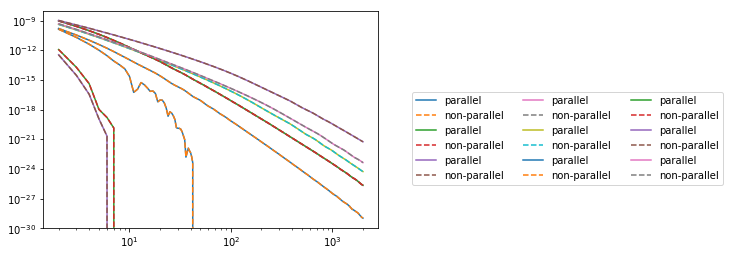

In [52]:
# comparing to parallel code
clphipsi_para=np.load('../G_matrices/clphipsi_parallel.npy')
clphipsi_para =np.swapaxes(clphipsi_para,0,1)
clphipsi_para.shape
for ii in [10,50,90]:
        for jj in [10,50,90]:
            plt.loglog(ell_,abs(clphipsi_para[:,ii,jj]),label='parallel')
            plt.loglog(ell_,abs(Cl[:,ii,jj]),ls='--',label='non-parallel')
plt.legend(ncol=3, loc=(1.1,0.2))

### tesing gaussian quadrature with simple integral test
$\int_0^1 \mathrm{d} x x^2 = 1/2 \sum_i w_i t_i^2 = 1/3 $

In [37]:
0.5*np.sum(w1*t_**2)

0.33333333387229197

## 2) $ G_l^{\phi\delta}(\chi_{max}, \chi_2) = \int_0^{\chi_{max}} \mathrm{d} \chi_1 W(\chi_1, \chi_{max}) C_l^{\psi\delta}(\chi_1,\chi_2)$ 
$= \mathcal{A} \frac{2}{2\pi^2} \sum_n \int_0^1  \chi_2^{(1-\nu_n)} D(\chi_2) I^2_l (\nu_n,t)\left[W(t\chi_2,\chi_{max}) D(\chi_2 t) [1+z(\chi_2 t)] + W(1/t \chi_2,\chi_{max}) t^{(2+\nu_n)-2}D(\chi_2/t)[1+z(\chi_2/t)]\right]$

In [38]:
#define different redshift kernels (at some point load this)

# 1) general kernel if dNdz is Gaussian
def Gauss_redshift(z0,sigma_z):
    def z_kernel(z):
        return 1./np.sqrt(2.*np.pi)/sigma_z*np.exp(-(z-z0)**2/2./sigma_z**2)
    return z_kernel

def gal_kernel(z_kernel,ximax=5):
    def chi_kernel(xi):
        return z_kernel(z_chi(xi))*dz_dchi(xi)
    return chi_kernel


# 2) prospective LSST kernels
def dNdz_LSST(bin_num,dn_filename = '../LSSTdndzs/dndz_LSST_i27_SN5_3y'):
    if bin_num is "all":
        zbin, nbin = np.load(dn_filename+'tot_extrapolated.npy',encoding='latin1')
        norm                = np.trapz(nbin,zbin)
        mbin                = 'None'
    else:
        bins,big_grid,res   = np.load(dn_filename+'_extrapolated.npy',encoding='latin1')
        mbin                = bins[bin_num]
        zbin                = big_grid
        nbin                = res[bin_num]
        norm                = np.trapz(nbin,zbin)
    dndz                = interp1d(zbin, nbin/norm, kind='linear',bounds_error=False,fill_value=0.)
    print('using z-bin', mbin, 'norm', norm)
    return dndz



def gal_clus(dNdz,b,bin_num):
    """
    dNdz: function returning function dndz for gicen bin number 
    b: function returning bias as function of z 
    bin_num: bin_number (either 'all' or 0-5)
    """
    p_z=dNdz(bin_num)
    def kernel(x):
        z = z_chi(x)
        return b(z)*p_z(z)*dz_dchi(z)

    return kernel

def simple_bias(z):
    return (1.+z)

def constant_bias(z,b=1.):
    return b

In [31]:
# tested against chirags parallelized version
def lensing_kernel(xi, xmax):
    return (xmax - xi)/(xmax*xi) * (xmax > xi)

r2d, t2d = np.meshgrid(t_,t_)
w11, w12 = np.meshgrid(w1,w1)
#nu axis
r2d, t2d = np.expand_dims(r2d, 2), np.expand_dims(t2d, 2)
w11, w12 = np.expand_dims(w11, 2), np.expand_dims(w12, 2)


chimax2   = chi_cmb

n = 2

Cl = np.zeros((len(t_),len(ell_),len(t_)))

begin=time.time()

for jj, chimax1 in enumerate((t_*chi_cmb)):
    if jj%10==0:
        print(jj)
        
    chi1fac0  = D_chi(r2d*chimax2)
    chi1fac0  = chi1fac0 *(r2d*chimax2)**(1-(n+nu_n_).reshape(1, 1, -1))

    chi2fac00 = (D_chi(r2d*t2d*chi2_max)*(1+z_chi(r2d*t2d*chi2_max))*lensing_kernel(r2d*t2d*chi2_max, chimax1))
    
    chi2fac01 = (lensing_kernel(1./t2d*r2d*chimax2,chimax1)*D_chi(r2d*1./t2d*chimax2)*(1+z_chi(r2d*1./t2d*chimax2)))
    chi2fac01 = chi2fac01 * t2d**((n+nu_n_).reshape(1, 1, -1)-2)
    chi2fac0  = chi2fac00 + chi2fac01

    chifacs   = w12*chi1fac0* chi2fac0

    result    = np.zeros((len(ell_),len(t_)))
    lmax = ell_.size
    for ii  in range(ell_.size):        
        result[ii] = np.sum(chifacs*I2_ltrc[ii],axis=(0,2))
    
    Cl[jj] = result*1./np.pi**2/2.*prefac/2.*2

Cl = np.swapaxes(Cl,0,1)
print('Time taken = ', time.time()-begin)


# first axis ell, second phi, third delta
np.save('../G_matrices/clphidelta',Cl)

0


/global/homes/v/vboehm/.conda/envs/bccp/lib/python3.6/site-packages/ipykernel_launcher.py:38: ComplexWarning: Casting complex values to real discards the imaginary part


10
20
30
40
50
60
70
80
90
Time taken =  157.4574203491211


### 4) $ G_l^{\psi\delta}(\chi_1, \chi_2) 
= \mathcal{A} \frac{1}{2\pi^2} D(\chi_2) D(\chi_1)  [1+z(\chi_1)] \sum_n \left[I^{(2)}_l (\nu_n,\chi_1/\chi_2)\chi_2^{-(\nu_n+2)} +I^{(2)}_l (\nu_n,\chi_2/\chi_1) \chi_1^{-(\nu_n+2)}\right]
= \frac{\mathcal{A}}{2\pi^2} \sum_n [1+z(tr\chi_{cmb})] D(tr\chi_{cmb})D(r\chi_{cmb}) I^{(2)}_l (\nu_n,t) (r \chi_{cmb})^{-(\nu_n+n)}$

In [37]:
Cl = np.zeros((len(ell_),len(t_),len(t_)))

# delta goes all the way to chi_cmb, psi is the dependent one
chi1fac0  = D_chi(r2d*chi_cmb)
chi1fac0  = chi1fac0 *(r2d*chi_cmb)**(-(n+nu_n_).reshape(1, 1, -1))
chi2fac0  = (D_chi(r2d*t2d*chi_cmb)*(1+z_chi(r2d*t2d*chi_cmb)))
    
chifacs   = chi2fac0 * chi1fac0

chifacs   = chi1fac0* chi2fac0


for ii  in range(ell_.size):        
    Cl[ii] = np.sum(chifacs*I2_ltrc[ii],axis=(2))*1./np.pi**2/2.*prefac
    
    
np.save('../G_matrices/cldeltapsi',Cl)

/global/homes/v/vboehm/.conda/envs/bccp/lib/python3.6/site-packages/ipykernel_launcher.py:13: ComplexWarning: Casting complex values to real discards the imaginary part
  del sys.path[0]


In [40]:
r2d[0]

array([[1.43136613e-04],
       [7.54024680e-04],
       [1.85243263e-03],
       [3.43753148e-03],
       [5.50780238e-03],
       [8.06122965e-03],
       [1.10953208e-02],
       [1.46071121e-02],
       [1.85931729e-02],
       [2.30496085e-02],
       [2.79720649e-02],
       [3.33557325e-02],
       [3.91953509e-02],
       [4.54852145e-02],
       [5.22191775e-02],
       [5.93906603e-02],
       [6.69926558e-02],
       [7.50177361e-02],
       [8.34580601e-02],
       [9.23053808e-02],
       [1.01551054e-01],
       [1.11186045e-01],
       [1.21200941e-01],
       [1.31585955e-01],
       [1.42330941e-01],
       [1.53425400e-01],
       [1.64858492e-01],
       [1.76619046e-01],
       [1.88695570e-01],
       [2.01076265e-01],
       [2.13749034e-01],
       [2.26701494e-01],
       [2.39920990e-01],
       [2.53394605e-01],
       [2.67109175e-01],
       [2.81051299e-01],
       [2.95207354e-01],
       [3.09563509e-01],
       [3.24105737e-01],
       [3.38819828e-01],


(289, 100, 100)


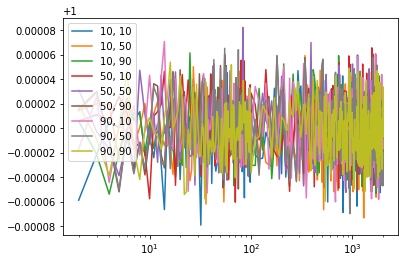

In [9]:
# comparing Chirags and mine Cl_phiphi(x1,x2)
clphiphi1 = np.load('../G_matrices/clphiphi_parallel.npy')
print(clphiphi1.shape)
clphiphi2 = np.load('../output/clphiphi-samenew.npy')
for ii in [10,50,90]:
    for jj in [10,50,90]:
        plt.semilogx(ell_,clphiphi1[:,ii,jj]/clphiphi2[:,ii,jj], label ='%d, %d'%(ii,jj))
plt.legend()
#--> they agree

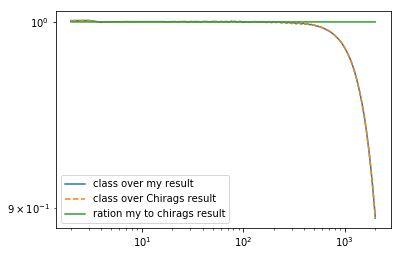

In [32]:
# and the x1=x2=x_cmb limit agrees with class
ll,clpp = np.load('../output/clpp_class_no_limber.npy')
plt.loglog(ell_,np.interp(ell_,ll,clpp)/clphiphi1[:,99,99], label='class over my result')
plt.loglog(ell_,np.interp(ell_,ll,clpp)/clphiphi2[:,99,99], ls='--', label='class over Chirags result')
plt.loglog(ell_, clphiphi1[:,99,99]/clphiphi2[:,99,99], label='ration my to chirags result')
plt.legend()